# Import Libraries & Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import CCA
from scipy import signal
import mne
import matplotlib.pyplot as plt

In [2]:
subject = 'Sub01'
date = '7_24_EEG'

df = pd.DataFrame()
sfreq = 250

for i in [1]:
    # data_path = f'../../data/{date}/{subject}/Katie_7-23_EEG_no_OSCAR_{i}.csv'
    data_path = f'../../data/{date}/{subject}/{subject}_EEG_cleaned_{i}.csv'
    eeg = pd.read_csv(data_path)
    df = pd.concat([df, eeg])

In [3]:
channels = [f"EEG_Ch{i}(mV)" for i in range(1, 9)] # Select channels you want
eeg_data = df[channels].to_numpy()
labels = df['filled_stim'].to_numpy()

(array([40651.,     0.,     0.,     0.,     0., 25434.,     0.,     0.,
            0., 24993.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

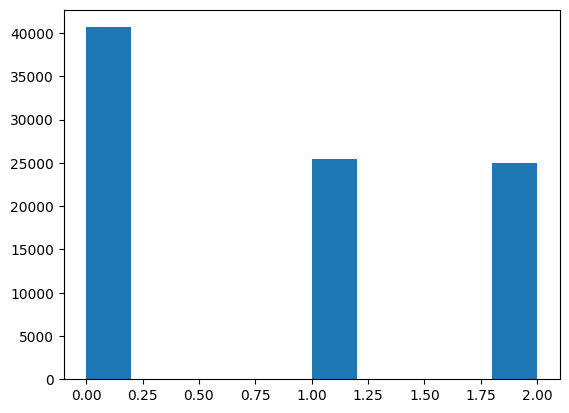

In [4]:
plt.hist(labels)

# Filter Data

### MNE

In [368]:
info = mne.create_info([f'EEG_{i}' for i in range(eeg_data.shape[1])], sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data.T, info)

# Apply bandpass filter
raw_bandpass = raw.copy().filter(l_freq=0.5, h_freq=50)

# Apply notch filter
raw_filtered = raw_bandpass.copy().notch_filter(freqs=60)

eeg_data = raw_filtered.get_data().T

Creating RawArray with float64 data, n_channels=8, n_times=82723
    Range : 0 ... 82722 =      0.000 ...   330.888 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atte

### Scipy

In [ ]:
# Define filter parameters
fs = 250
lowcut = 0.5  # Lower frequency of the bandpass
highcut = 50  # Upper frequency of the bandpass
notch_freq = 60  # Frequency to be removed by notch filter
Q = 30  # Quality factor for notch filter

In [ ]:
# Create bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

In [ ]:
# Create notch filter
def notch_filter(notch_freq, Q, fs):
    b, a = signal.iirnotch(notch_freq, Q, fs)
    return b, a

In [ ]:
# Get filter coefficients
b_bandpass, a_bandpass = butter_bandpass(lowcut, highcut, fs)
b_notch, a_notch = notch_filter(notch_freq, Q, fs)

In [ ]:
# Apply filters
signal_bandpass = signal.filtfilt(b_bandpass, a_bandpass, eeg_data.T)
eeg_data_filtered = signal.filtfilt(b_notch, a_notch, signal_bandpass)

In [ ]:
eeg_data = eeg_data_filtered.T

# Epoch Data & CCA Analysis

In [5]:
class CCAAnalysis:
    """Canonical Correlation Analysis for SSVEP paradigm"""
    def __init__(self, freqs, win_len, s_rate, n_harmonics=1):
        """
        Args:
            freqs (list): List of target frequencies
            win_len (float): Window length
            s_rate (int): Sampling rate of EEG signal
            n_harmonics (int): Number of harmonics to be considered
        """
        self.freqs = freqs
        self.win_len = win_len
        self.s_rate = s_rate
        self.n_harmonics = n_harmonics
        self.train_data = self._init_train_data()
        self.cca = CCA(n_components=1)

    def _init_train_data(self):
        t_vec = np.linspace(0, self.win_len, int(self.s_rate * self.win_len))
        targets = {}
        for freq in self.freqs:
            sig_sin, sig_cos = [], []
            for harmonics in range(self.n_harmonics):
                sig_sin.append(np.sin(2 * np.pi * harmonics * freq * t_vec))
                sig_cos.append(np.cos(2 * np.pi * harmonics * freq * t_vec))
            targets[freq] = np.array(sig_sin + sig_cos).T
        return targets

    def apply_cca(self, eeg):
        """Apply CCA analysis to EEG data and return scores for each target frequency

        Args:
            eeg (np.array): EEG array [n_samples, n_chan]

        Returns:
            list of scores for target frequencies
        """
        scores = []
        for key in self.train_data:
            sig_c, t_c = self.cca.fit_transform(eeg, self.train_data[key])
            scores.append(np.corrcoef(sig_c.T, t_c.T)[0, 1])
        return scores

In [6]:
def get_epoch_idxs(arr):
    result = []
    current_subarray = [[0, arr[0]]]
    
    for i in range(1, len(arr)):
        if arr[i] == arr[i-1]:
            current_subarray.append([i, arr[i]])
        else:
            result.append(np.array(current_subarray))
            current_subarray = [[i, arr[i]]]
    
    result.append(np.array(current_subarray))
    return result

In [7]:
epoch_idxs = get_epoch_idxs(labels)
epoched_data = [eeg_data[list(map(int, idxs[:,0])), :] for idxs in epoch_idxs]

groundtruth = [np.mean(idxs[:, 1]) for idxs in epoch_idxs]

In [8]:
X = [epoched_data[i] for i in np.where(np.array(groundtruth) != 0)[0]]
y = [groundtruth[i] for i in np.where(np.array(groundtruth) != 0)[0]]
y = [0 if i == 1 else 1 for i in y]

In [9]:
# Removes any detected epochs who number of samples are less than the sampling rate

y = [y[i] for i in range(len(y)) if len(X[i]) > 2*sfreq]
X = [data for data in X if len(data) > 2*sfreq]

In [10]:
t_min = -1
t_max = 6.
event_freq = [9.75, 14.25]
fs = 250
# t_win = [.25, .5, .75, 1, 1.25, 1.5, 2, 2.5, 3, 4, 6] # multiple time windows
t_win = [3] # one time window

predictions = {str(key): [] for key in t_win}
accuracies = []

X_new = []

for tmax in t_win:
    cca = CCAAnalysis(freqs=event_freq, win_len=tmax, s_rate=fs, n_harmonics=2)

    epochs = []
    idxs = []
    groundtruth = []
    
    for trial_data in X:
        if trial_data.shape[0] < int(fs*tmax):
            trial_data = np.vstack((trial_data, np.zeros((int(fs*tmax) - trial_data.shape[0], trial_data.shape[1]))))
        X_new.append(trial_data[:int(fs*tmax),:])
        scores = cca.apply_cca(trial_data[:int(fs*tmax),:])
        predictions[str(tmax)].append(np.argmax(scores))
        
    accuracies.append(np.mean(np.array(predictions[str(tmax)]) == y) * 100)

In [11]:
print("Accuracy\n----------------")
print(accuracies)

Accuracy
----------------
[95.0]


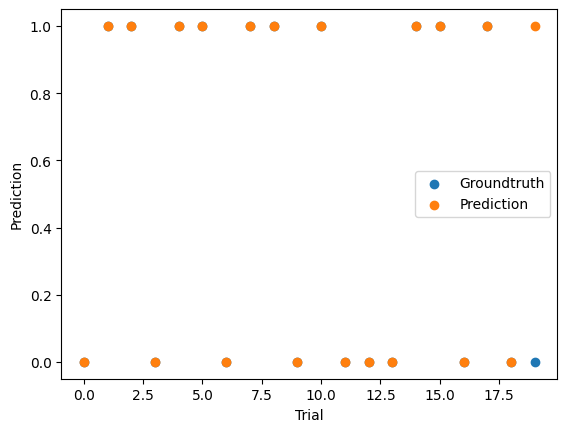

In [12]:
# Visualize predictions
plt.scatter(np.arange(len(y)), y, label='Groundtruth')
plt.scatter(np.arange(len(predictions[f'{t_win[0]}'])), predictions[f'{t_win[0]}'], label='Prediction')
plt.xlabel('Trial')
plt.ylabel('Prediction')
plt.legend()

In [13]:
# Change dimensions to make compatible with the TFR analysis
X_new = np.array(X_new)
X_new = np.transpose(X_new, (0, 2, 1))

y = np.array(y)

# Time Frequency Analysis

In [14]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

ch_labels = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]
# ch_labels = ch_labels[4:]

In [15]:
def tfr_analysis(X, y, n_channels:int, fs:int, event_freq:list):
    """
    Parameters
    ----------
        X : np.array
            EEG data [n_trials, n_channels, n_samples]

        y : np.array
            Labels [n_trials]
        
        n_channels : int
            Number of channels
        
        fs : int
            Sampling rate of EEG data
`
        event_freq : list
            List of frequencies SSVEP stimuli is flashing at
    """
    freqs = np.arange(0.5, 20., .5)
    n_cycles = freqs

    times = np.linspace(0, 4, np.array(X).shape[2])

    power_1 = mne.time_frequency.tfr_array_morlet(X[np.where(y == 0.)[0], :, :], sfreq=fs,
                                                    freqs=freqs, n_cycles=n_cycles, zero_mean=True,
                                                    output='avg_power')
    power_2 = mne.time_frequency.tfr_array_morlet(X[np.where(y == 1.)[0], :, :], sfreq=fs,
                                                    freqs=freqs, n_cycles=n_cycles, zero_mean=True,
                                                    output='avg_power')

    mne.baseline.rescale(power_1, times, (None, 0), mode='mean', copy=False)
    mne.baseline.rescale(power_2, times, (None, 0), mode='mean', copy=False)

    power = np.stack([power_1, power_2])
    x, y = mne.viz.centers_to_edges(times, freqs)

    fig, ax = plt.subplots(n_channels, 2, figsize=(10, 5*n_channels))


    for j in range(2):
        for i in range(n_channels):
            ax[i, j].set_title(f'{event_freq[j]} Hz')
            mesh = ax[i, j].pcolormesh(x, y, power[j, i], cmap='RdBu_r')
            # ax[i, j].set_title('TFR - ' + chan_name[i] + ' - ' + class_names[j])
            ax[i, j].set(ylim=freqs[[0, -1]])
            
            ax[i, j].set_xlabel('Time (s)')
            if j == 0:
                ax[i, j].set_ylabel(f'{ch_labels[i]} | Frequency (Hz)')

            # Adding xticks
            xtick_positions = np.linspace(0, 4, num=4)
            xtick_labels = np.round(np.linspace(0, t_win[0], num=4), 2)
            ax[i, j].set_xticks(xtick_positions)
            ax[i, j].set_xticklabels(xtick_labels)


    plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    # fig.subplots_adjust(top = .95)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # fig.colorbar(mesh, cax=cbar_ax)

    # fig.suptitle('Time-Frequency Representation', fontsize=18)

    # plt.savefig(f'figures/{subject}_{date}_TFR_{t_win[0]}_sec.svg')

    plt.show()

In [16]:
X_new.shape

(20, 8, 750)

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


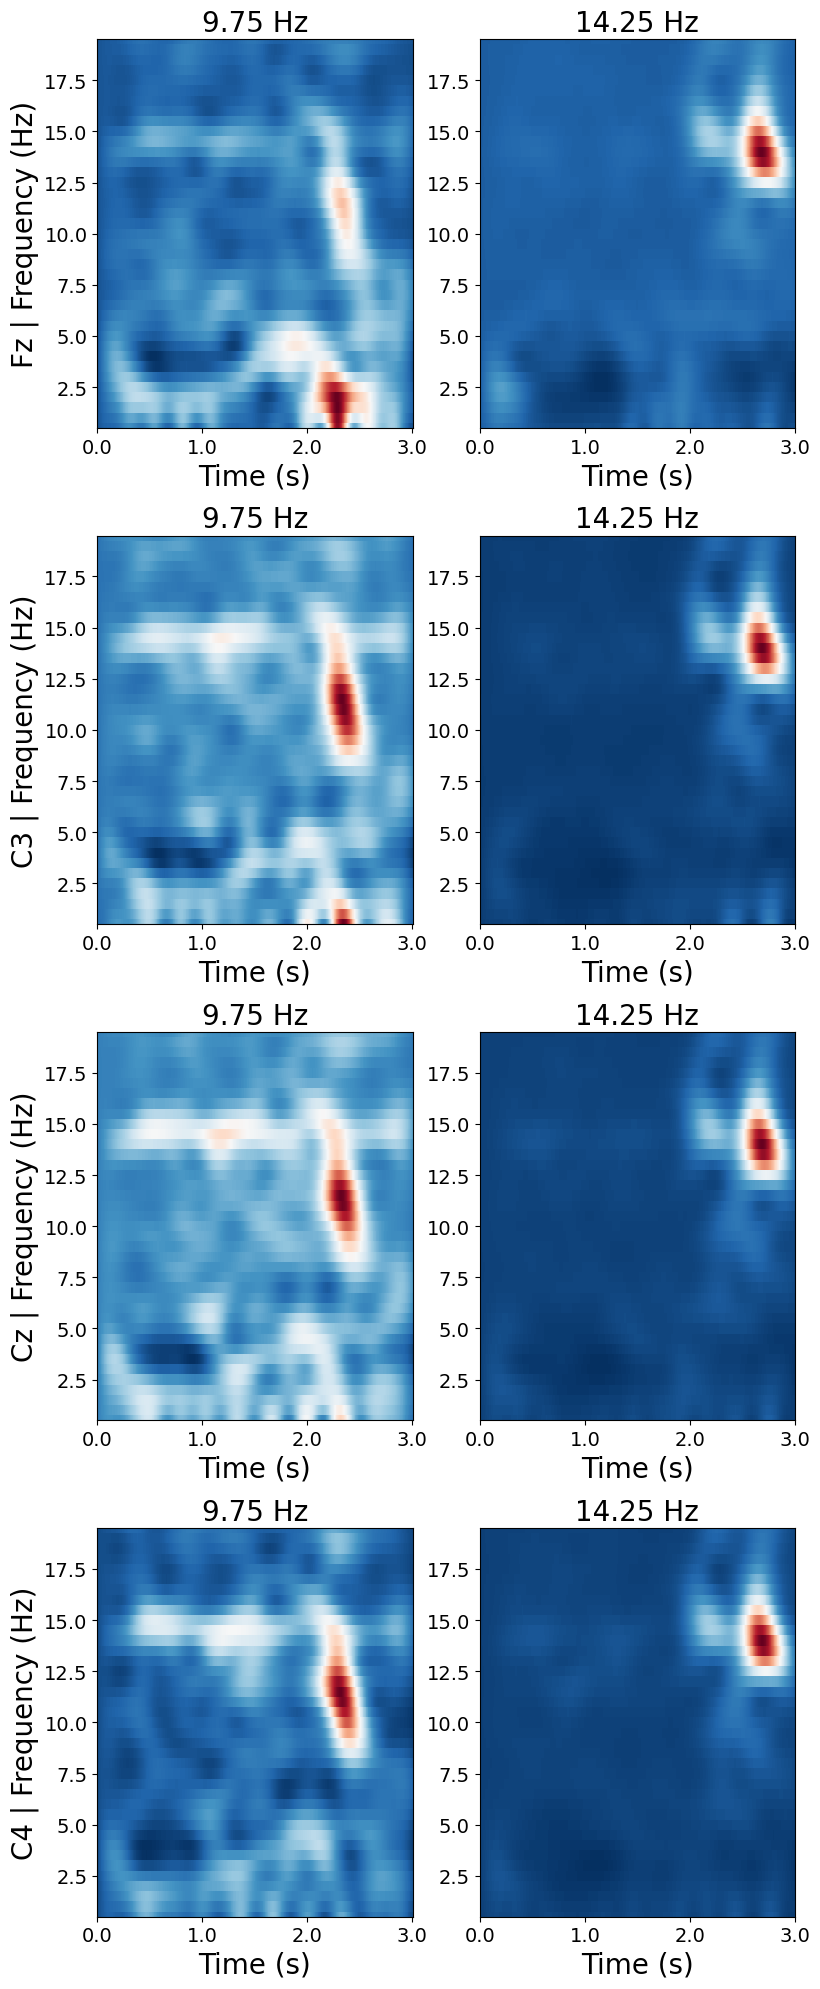

In [17]:
fs = 250
n_channels = eeg_data.shape[1]
event_freq = [9.75, 14.25]

tfr_analysis(X_new[:, :4, :], y, n_channels//2, fs, event_freq)

# Test on Dataset

In [18]:
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import MAMEM3
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import SSVEP
from moabb.pipelines import SSVEP_CCA


# warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action="ignore", category=RuntimeWarning)
moabb.set_log_level("info")

In [19]:
subj = [1, 3]
dataset = MAMEM3()
dataset.subject_list = subj

In [ ]:
paradigm = SSVEP(fmin=3, fmax=15, n_classes=3)

In [21]:
interval = dataset.interval
freqs = paradigm.used_events(dataset)

pipeline = {}
pipeline["CCA"] = make_pipeline(SSVEP_CCA(interval=interval, freqs=freqs, n_harmonics=3))

In [ ]:
sessions = dataset.get_data(subjects=[3])
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[3])
y = np.array([0 if label == '6.66' else 1 for label in labels])

In [ ]:
X.shape

In [27]:
t_min = -1
t_max = 6.
event_freq = [3, 7]
fs = 128
t_win = [.25, .5, .75, 1, 1.25, 1.5, 2, 2.5, 3]

predictions = {str(key): [] for key in t_win}
accuracies = []

for tmax in t_win:
    cca = CCAAnalysis(freqs=event_freq, win_len=tmax, s_rate=fs, n_harmonics=2)

    for trial in X:
        scores = cca.apply_cca(trial.T[:int(tmax*fs), :])
        predictions[str(tmax)].append(np.argmax(scores))

    accuracies.append(np.mean(np.array(predictions[str(tmax)]) == y) * 100)

In [ ]:
accuracies

### TFR Analysis

In [ ]:
fs = 128
event_freq = [6.66, 8.57]
n_channels = 5


tfr_analysis(X, y, X.shape[1], fs, event_freq)